In [1]:
import torch #should be installed by default in any colab notebook
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import os
import shutil
import torch.utils.data as data

from typing import *


import time
import copy

In [2]:
!pwd

/home/carlos/PycharmProjects/Master/C3/project23-24-08/Task2


In [3]:
torch.cuda.is_available()

True

In [4]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
TRAIN_DATASET_DIR="../Task1/MIT_split/train/"
TEST_DATASET_DIR = "../Task1/MIT_split/test/"

In [7]:
print(os.listdir(TRAIN_DATASET_DIR))
#shutil.rmtree('.ipynb_checkpoints')
print(os.listdir(TRAIN_DATASET_DIR))



['inside_city', 'coast', 'Opencountry', 'mountain', 'forest', 'street', 'tallbuilding', 'highway']
['inside_city', 'coast', 'Opencountry', 'mountain', 'forest', 'street', 'tallbuilding', 'highway']


In [8]:
BATCH_SIZE = 32



TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATASET_DIR,  transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATASET_DIR, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 
dataloaders_dict = {"train":train_loader, "val":test_loader}

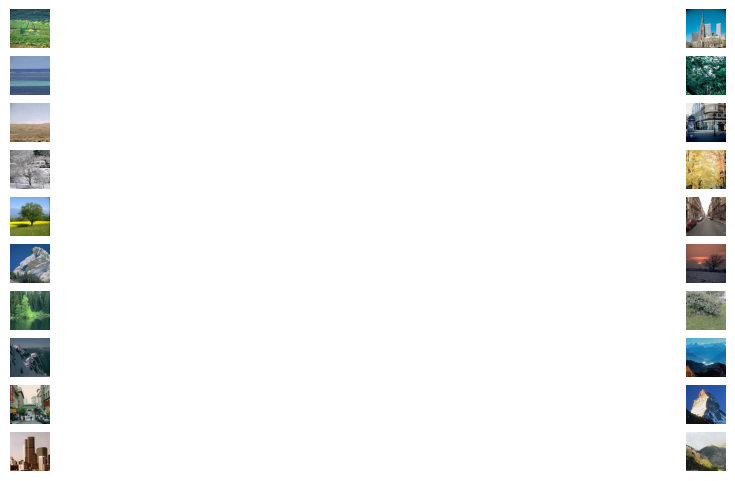

In [9]:
# show some images
import matplotlib.image as mpimg

plt.figure(figsize=(16, 6))
for i in range(20):
    plt.subplot(10, 2, i + 1)
    idx = np.random.randint(0,len(train_loader.dataset.samples))
    image = mpimg.imread(train_loader.dataset.samples[idx][0])
    plt.imshow(image)
    plt.axis('off');


In [194]:
class FCModel(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self._fc1 = nn.Linear(input_size, n_hidden[0]) 
        self._lnorm1 = nn.LayerNorm(n_hidden[0])
        
        self._fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self._lnorm2 = nn.LayerNorm(n_hidden[1])
        
        self._fc3 = nn.Linear(n_hidden[1], n_hidden[1]//2)
        self._lnorm3 = nn.LayerNorm(n_hidden[1]//2)
        
        self._drop = nn.Dropout(0.4)
        
        self._out = nn.Linear(n_hidden[1]//2, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self._fc1(x)
        x = self._lnorm1(x)
        x = F.relu(x)
        x = self._drop(x)
        x = self._fc2(x)
        x = self._lnorm2(x)
        x = F.relu(x)
        x = self._drop(x)
        x_out = self._fc3(x)
        x = F.relu(x_out)
        x = self._out(x)
        
        return x, F.softmax(x, dim=1), x_out
    
    
    
class FC_SVM(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC_SVM, self).__init__()
        self.input_size = input_size
        self._fc1 = nn.Linear(input_size, n_hidden[0]) 
        self._lnorm1 = nn.LayerNorm(n_hidden[0])
        
        self._fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self._lnorm2 = nn.LayerNorm(n_hidden[1])
        
        self._fc3 = nn.Linear(n_hidden[1], n_hidden[1]//2)
        self._lnorm3 = nn.LayerNorm(n_hidden[1]//2)
        
        self._drop = nn.Dropout(0.4)
        
        self._out = nn.Linear(n_hidden[1]//2, output_size)
        
        self._read_out = nn.Parameter(torch.empty((n_hidden[1]//2, output_size)), requires_grad=True)
        torch.nn.init.kaiming_uniform_(self._read_out)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self._fc1(x)
        x = self._lnorm1(x)
        x = F.relu(x)
        x = self._drop(x)
        x = self._fc2(x)
        x = self._lnorm2(x)
        x = F.relu(x)
        x = self._drop(x)
        x_out = self._fc3(x)
        x = F.relu(x_out)
        x = x @ self._read_out
        
        return x, torch.abs(x), self._read_out
    

    
    
    
def save_model(model_state_dict: object, path, filename:str) -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    torch.save(model_state_dict(), os.path.join(path, filename))
    
    
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, mode:str=None):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                
#                inputs = inputs.mean(dim=1)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    
                    if mode == "svm":
                        outputs, p, read_out = model(inputs)                     
                        loss = criterion(outputs, read_out, labels, 8)
                    else:
                        outputs, p,_ = model(inputs)
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(p, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())
            losses[phase].append(epoch_loss)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses


@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):
    
    activation = {"_fc3":[]}
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name].append(output.detach())
        return hook

    model._fc3.register_forward_hook(get_activation('_fc3'))


    val_loss = 0
    correct = 0

    model.eval()
    outts = []
    predictions = []
    scores = np.array([[]]).reshape((-1, 8))
    y_true = []
    for data, target in loader:
        y_true += list(target.numpy())
        data, target = data.to(device), target.to(device)

        data = data.view(-1, 32*32*3)
        output, p, last_l = model(data)
        scores = np.concatenate((scores, p.cpu().numpy()))
        outts.append(last_l)
        
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        scr, pred = p.data.max(1, keepdim=True) # get the index of the max log-probability   
        #scores += (list(scr.cpu().numpy()))
        predictions += (list(pred.cpu().numpy()))
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss, accuracy,  activation, outts, predictions, scores, y_true


def SVM_Loss(output, weight, y_true, num_classes):
    y = F.one_hot(y_true, num_classes = num_classes).to(output.device)
    y[y!=1] = -1
    tmp = torch.zeros_like(y).to(y.device)
    regularizer = torch.mean(weight.T@weight)
    maximum = torch.maximum(tmp, 1 -  y * output )
    loss = torch.mean(maximum)
    
    return regularizer + loss * 0.2


#criterion = SVM_Loss

In [135]:
histogram_parameters = []


In [136]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility



input_size  = 32*32*3
output_size = 8      # there are 10 classes

ins = 256

model = FCModel(input_size, (ins, ins), output_size)

# utility function to count number of parameters in a model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [137]:
print(f"Number of parameters {get_n_params(model)}:")

Number of parameters 887688:


In [138]:
histogram_parameters.append(get_n_params(model))

In [139]:
histogram_parameters

[887688]

In [140]:
results_per_epocs = {50:{"parameters": histogram_parameters, "acc_val": [], "acc_train": []}}


## Varying the optimizer

In [17]:
# move model to gpu if available
model = FCModel(input_size, (256,256), output_size)
model.to(device)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-2)

In [ ]:
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs= 50)

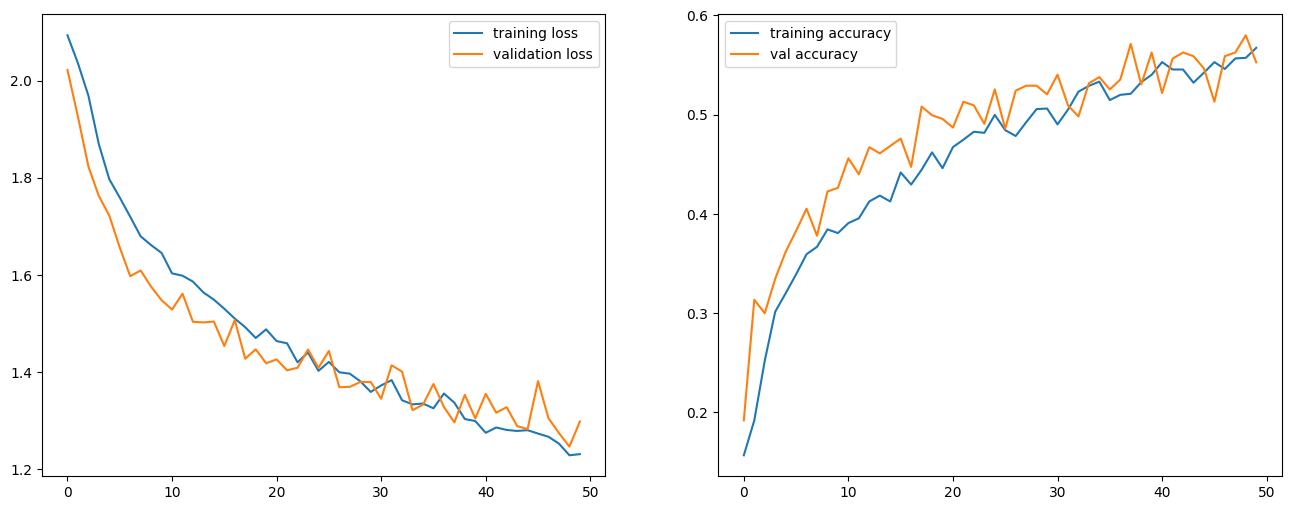

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["val"],label="val accuracy")
ax2.legend()

plt.show() 

In [142]:
model = FCModel(input_size, (256,256), output_size)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model2, hist2, losses2 = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=100)

In [144]:
save_model(model_state_dict=model2.state_dict, path="." ,filename="MLP_end2end_100_25M.pt")

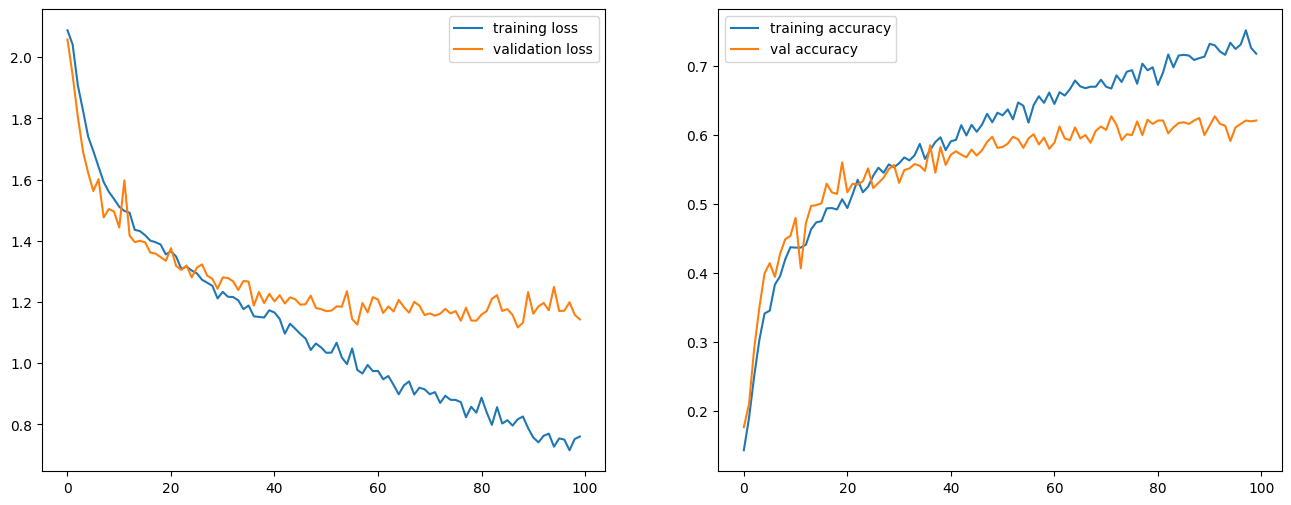

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(losses2["train"], label="training loss")
ax1.plot(losses2["val"], label="validation loss")
ax1.legend()

ax2.plot(hist2["train"],label="training accuracy")
ax2.plot(hist2["val"] ,label="val accuracy")
ax2.legend()

plt.show() 

In [195]:
_, acc_test, activation_train, outputs_layer_test, preds_test, scores_test, y_true_test = validate(criterion=criterion, model=model2, loader=dataloaders_dict["val"])
_, acc_train, activation_test, outputs_layer_train, preds_train, scores_train, _ = validate(criterion=criterion, model=model2, loader=dataloaders_dict["train"])



Test set: Average loss: 0.0376, Accuracy: 503/807 (62%)


Test set: Average loss: 0.0200, Accuracy: 1472/1881 (78%)



In [196]:
scores_test.shape

(807, 8)

In [182]:
scores_test = (scores_test)
preds_test = np.array(preds_test)
y_true_test = np.array(y_true_test)

In [177]:
y_true_test

array([7, 0, 7, 6, 2, 2, 3, 7, 2, 0, 0, 3, 3, 0, 0, 4, 3, 6, 3, 6, 3, 3,
       6, 0, 2, 4, 2, 6, 5, 0, 6, 1, 1, 5, 7, 3, 3, 5, 2, 3, 6, 7, 5, 1,
       4, 0, 4, 1, 2, 6, 6, 5, 6, 5, 0, 5, 3, 1, 6, 0, 2, 7, 6, 6, 0, 0,
       0, 7, 0, 0, 2, 7, 1, 2, 7, 7, 2, 0, 6, 7, 0, 0, 1, 1, 0, 4, 7, 4,
       2, 1, 3, 5, 2, 2, 2, 0, 5, 5, 7, 2, 6, 2, 0, 4, 7, 6, 4, 4, 1, 2,
       3, 1, 7, 3, 0, 4, 2, 0, 6, 2, 3, 2, 4, 4, 2, 7, 7, 7, 7, 1, 4, 1,
       2, 1, 4, 7, 4, 7, 4, 7, 7, 1, 7, 5, 5, 6, 2, 0, 2, 7, 1, 2, 4, 1,
       1, 4, 5, 1, 4, 6, 5, 6, 3, 4, 7, 0, 7, 4, 1, 0, 4, 1, 7, 5, 1, 5,
       1, 5, 2, 5, 4, 3, 2, 6, 3, 1, 0, 4, 4, 6, 1, 4, 2, 4, 3, 5, 2, 0,
       5, 6, 5, 2, 0, 0, 5, 6, 0, 5, 2, 0, 0, 1, 3, 3, 0, 2, 1, 2, 1, 5,
       1, 2, 0, 1, 0, 7, 2, 7, 1, 5, 5, 5, 4, 1, 3, 4, 0, 7, 2, 6, 7, 6,
       4, 3, 7, 1, 5, 6, 0, 1, 3, 7, 1, 1, 4, 1, 4, 2, 1, 7, 6, 5, 6, 4,
       0, 0, 0, 5, 5, 5, 7, 4, 0, 4, 0, 7, 0, 0, 2, 3, 1, 7, 2, 4, 4, 7,
       0, 0, 0, 0, 7, 2, 0, 5, 2, 2, 7, 0, 5, 1, 6,

In [183]:
preds_test[0] == y_true_test[0]

array([ True])

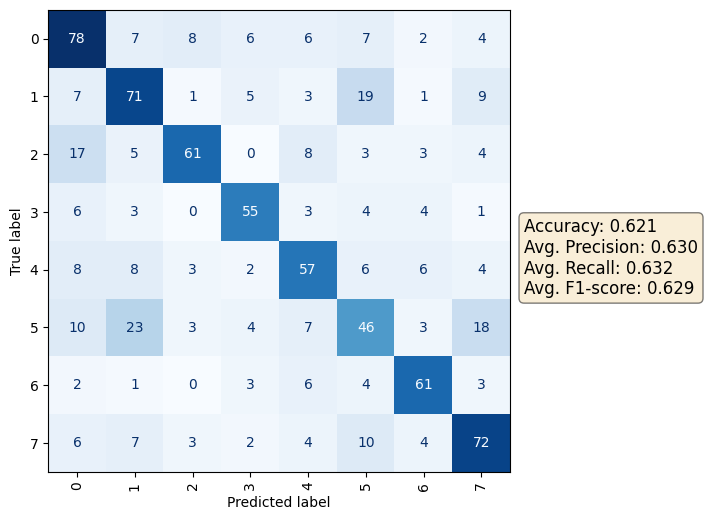

In [188]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_true_test, preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true_test))
_, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)

# Adding text for metrics
textstr = '\n'.join((
    f'Accuracy: {accuracy_score(preds_test, y_true_test):.3f}',
    f'Avg. Precision: {precision_score(preds_test, y_true_test, average="macro"):.3f}',
    f'Avg. Recall: {recall_score(preds_test, y_true_test, average="macro"):.3f}',
    f'Avg. F1-score: {f1_score(preds_test, y_true_test, average="macro"):.3f}'))

# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place a text box in upper left in axes coords
ax.text(1.03, 0.55, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.show()

In [200]:
scores_test

array([[6.66956999e-04, 2.78269895e-03, 1.64573677e-02, ...,
        7.36559276e-03, 8.06662161e-03, 1.05905288e-04],
       [2.96750337e-01, 3.01463790e-02, 3.10117975e-02, ...,
        5.02563976e-02, 2.50437200e-01, 5.99130206e-02],
       [3.43451812e-03, 1.64621114e-03, 1.92561900e-04, ...,
        9.55393761e-02, 1.31606997e-03, 8.70497823e-01],
       ...,
       [4.77146730e-03, 1.42861845e-03, 8.20819065e-02, ...,
        3.22486997e-01, 5.37186742e-01, 2.95063853e-02],
       [1.94638729e-01, 3.70240584e-02, 3.47620063e-03, ...,
        2.74092164e-02, 4.05290835e-02, 4.62532262e-05],
       [6.13892414e-02, 6.61066771e-02, 1.56215370e-01, ...,
        4.25243914e-01, 1.20139517e-01, 9.15073231e-03]])

(807, 8)
[0 1 2 3 4 5 6 7]


Text(0.5, 1.0, 'Micro-averaged Precision-Recall curve')

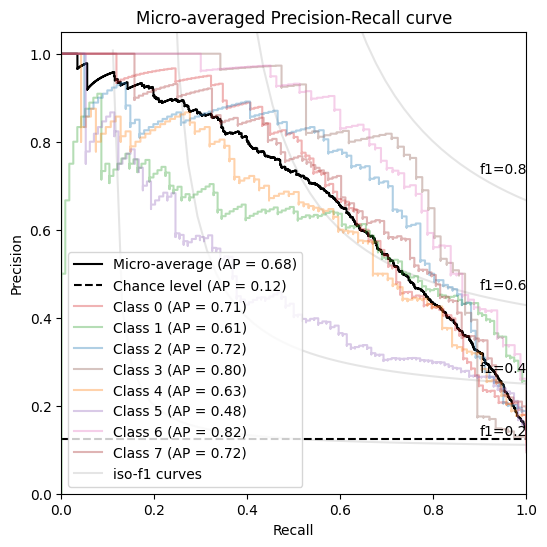

In [203]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]
enc = LabelBinarizer()


y_onehot_test = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(y_true_test).reshape(-1, 1)).toarray()
print(y_onehot_test.shape)
clas = (np.unique(y_true_test))
n_classes = y_onehot_test.shape[1]
print(clas)

# For each class
precision_dict  = dict()
recall_dict  = dict()
average_precision_dict = dict()
for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], scores_test[:, i])
    average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], scores_test[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), scores_test.ravel()
)
average_precision_dict["micro"] = average_precision_score(y_onehot_test, scores_test, average="micro")


from collections import Counter

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_dict["micro"],
    precision=precision_dict["micro"],
    average_precision=average_precision_dict["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(ax=ax, name="Micro-average", plot_chance_level=True, color='black')


for i, (cl, color) in enumerate(zip(clas, colors)):
    display = PrecisionRecallDisplay(
        recall=recall_dict[i],
        precision=precision_dict[i],
        average_precision=average_precision_dict[i],
    )
    display.plot(ax=ax, name=f"Class {i}", color=color, alpha=0.35)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Micro-averaged Precision-Recall curve")

In [240]:
train_features = outputs_layer_train[0].cpu().numpy() 
print(train_features.shape)
for output in outputs_layer_train[1:]:
    train_features = np.concatenate((train_features, output.cpu().numpy()), axis= 0)
    

(32, 64)


In [241]:
test_features =  outputs_layer_test[0].cpu().numpy()
for output in outputs_layer_test[1:]:
    test_features = np.concatenate((test_features, output.cpu().numpy()), axis= 0)

In [242]:
test_features.shape

(807, 64)

In [243]:
dataloaders_dict["train"].dataset.class_to_idx
mapping_idx_to_class = {j:i for i, j in dataloaders_dict["train"].dataset.class_to_idx.items()}

In [244]:
mapping_features = {img[0]: None for img in dataloaders_dict["train"].dataset.imgs}
embeddings = []
embeddings_indexes = []
phase = []
labels = []
for set_indexes in dataloaders_dict["train"].batch_sampler:
    for ii in set_indexes:
        idx_label = dataloaders_dict["train"].dataset.imgs[ii][1]
        mapping_features[dataloaders_dict["train"].dataset.imgs[ii][0]] = (train_features[ii], mapping_idx_to_class[idx_label])
        
        embeddings.append(train_features[ii])
        labels.append(mapping_idx_to_class[idx_label])
        embeddings_indexes.append(ii)
        phase.append("train")
        


In [245]:
mapping_features_test = {img[0]: None for img in dataloaders_dict["val"].dataset.imgs}
for set_indexes in dataloaders_dict["val"].batch_sampler:
    for ii in set_indexes:
        idx_label = dataloaders_dict["val"].dataset.imgs[ii][1]

        mapping_features_test[dataloaders_dict["val"].dataset.imgs[ii][0]] = (test_features[ii], mapping_idx_to_class[idx_label])
        
        embeddings.append(test_features[ii])
        labels.append(mapping_idx_to_class[idx_label])
        embeddings_indexes.append(ii)
        phase.append("test")


In [246]:
import pandas as pd
df = pd.DataFrame()

df["img"] = list(mapping_features.keys()) + list(mapping_features_test.keys())
df["labels"] = labels
df["embeddings_idx"] = embeddings_indexes
df["phase"] = phase


In [247]:
df

,img,labels,embeddings_idx,phase
0,../Task1/MIT_split/train/Opencountry/art582.jpg,Opencountry,142,train
1,../Task1/MIT_split/train/Opencountry/cdmc276.jpg,coast,413,train
2,../Task1/MIT_split/train/Opencountry/cdmc354.jpg,inside_city,953,train
3,../Task1/MIT_split/train/Opencountry/cdmc710.jpg,coast,382,train
4,../Task1/MIT_split/train/Opencountry/cdmc712.jpg,forest,749,train
...,...,...,...,...
2683,../Task1/MIT_split/test/tallbuilding/urban744.jpg,inside_city,475,test
2684,../Task1/MIT_split/test/tallbuilding/urban745.jpg,tallbuilding,749,test
2685,../Task1/MIT_split/test/tallbuilding/urban787.jpg,street,646,test
2686,../Task1/MIT_split/test/tallbuilding/urban828.jpg,coast,206,test


In [248]:
### Embeddings in 2 dimensions in order to plot them
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(np.array(embeddings))
df["x"] = embeddings_2d[:, 0]
df["y"] = embeddings_2d[:, 1]

In [249]:
embeddings_2d.shape

(2688, 2)

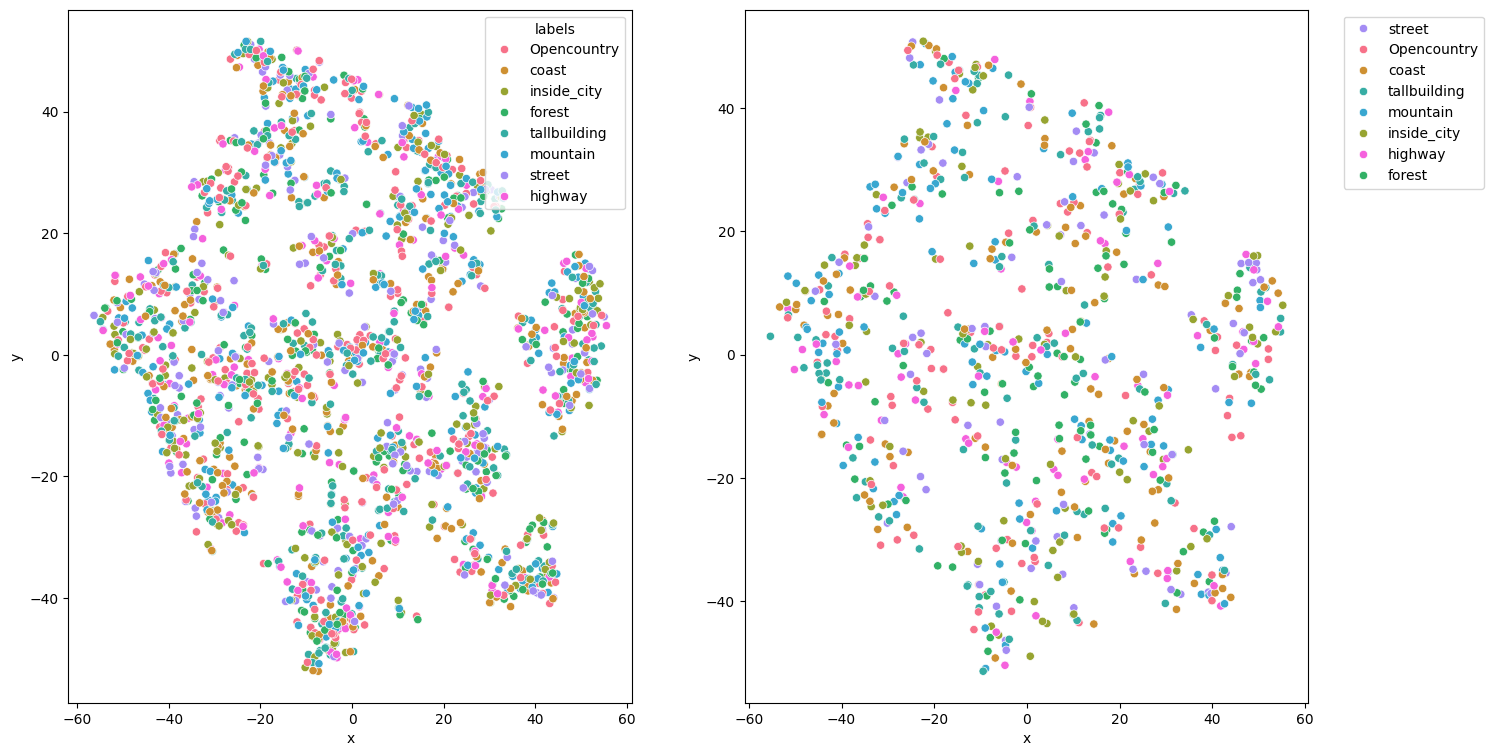

In [250]:
import seaborn as sns
fig, axs = plt.subplots(ncols=2, figsize=(16,9))
classes = df["labels"].unique()
class_colors = sns.color_palette("husl", n_colors=len(classes))

# Mapear clases a colores
class_color_dict = dict(zip(classes, class_colors))



sns.scatterplot(data = df[df["phase"]== "train"], x="x", y="y", hue = "labels", ax=axs[0], palette=class_color_dict)

sns.scatterplot(data = df[df["phase"]== "test"], x="x", y="y", hue = "labels", ax=axs[1], palette=class_color_dict)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda para el primer subgráfico

In [39]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.9)

In [40]:
model3, hist3, losses3 = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=100)


Epoch 0/99
----------
train Loss: 2.3342 Acc: 0.1653
val Loss: 2.0732 Acc: 0.1462
Epoch 1/99
----------
train Loss: 2.0814 Acc: 0.1515
val Loss: 2.0520 Acc: 0.2082
Epoch 2/99
----------
train Loss: 2.0622 Acc: 0.1643
val Loss: 2.0244 Acc: 0.1747
Epoch 3/99
----------
train Loss: 2.0378 Acc: 0.1839
val Loss: 1.9851 Acc: 0.2280
Epoch 4/99
----------
train Loss: 1.9900 Acc: 0.2052
val Loss: 1.9143 Acc: 0.2429
Epoch 5/99
----------
train Loss: 1.9218 Acc: 0.2430
val Loss: 1.7917 Acc: 0.2999
Epoch 6/99
----------
train Loss: 1.8644 Acc: 0.2802
val Loss: 1.6873 Acc: 0.3395
Epoch 7/99
----------
train Loss: 1.8100 Acc: 0.3121
val Loss: 1.6755 Acc: 0.3420
Epoch 8/99
----------
train Loss: 1.7347 Acc: 0.3291
val Loss: 1.6735 Acc: 0.3879
Epoch 9/99
----------
train Loss: 1.7063 Acc: 0.3626
val Loss: 1.5877 Acc: 0.3705
Epoch 10/99
----------
train Loss: 1.6558 Acc: 0.3674
val Loss: 1.5507 Acc: 0.3941
Epoch 11/99
----------
train Loss: 1.6195 Acc: 0.3961
val Loss: 1.5458 Acc: 0.4176
Epoch 12/99
--

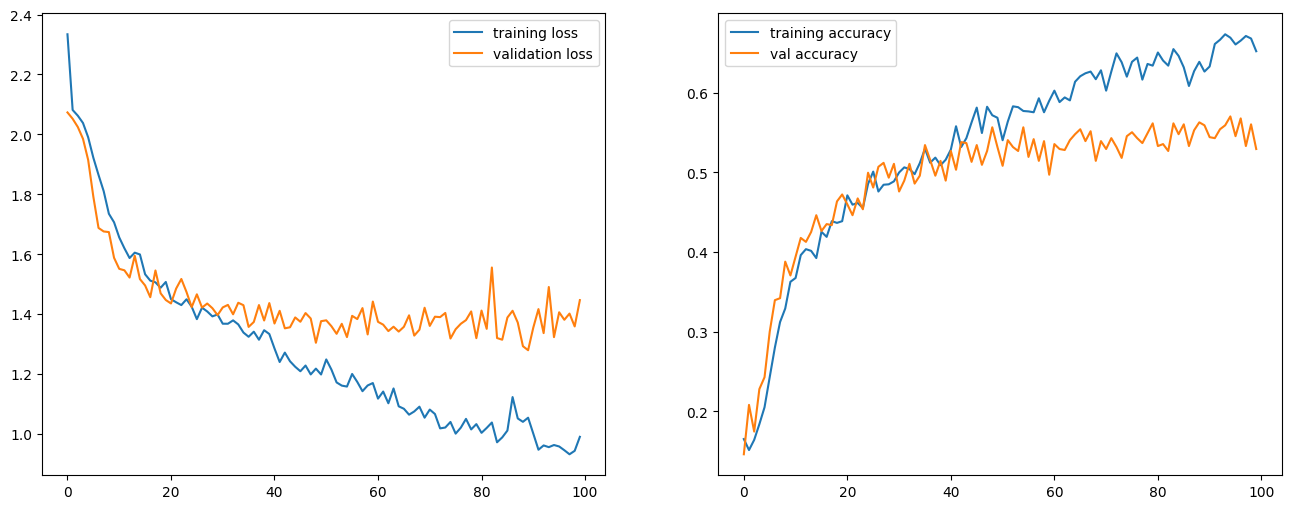

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses3["train"], label="training loss")
ax1.plot(losses3["val"], label="validation loss")
ax1.legend()

ax2.plot(hist3["train"],label="training accuracy")
ax2.plot(hist3["val"],label="val accuracy")
ax2.legend()

plt.show() 

## Comparing Performances

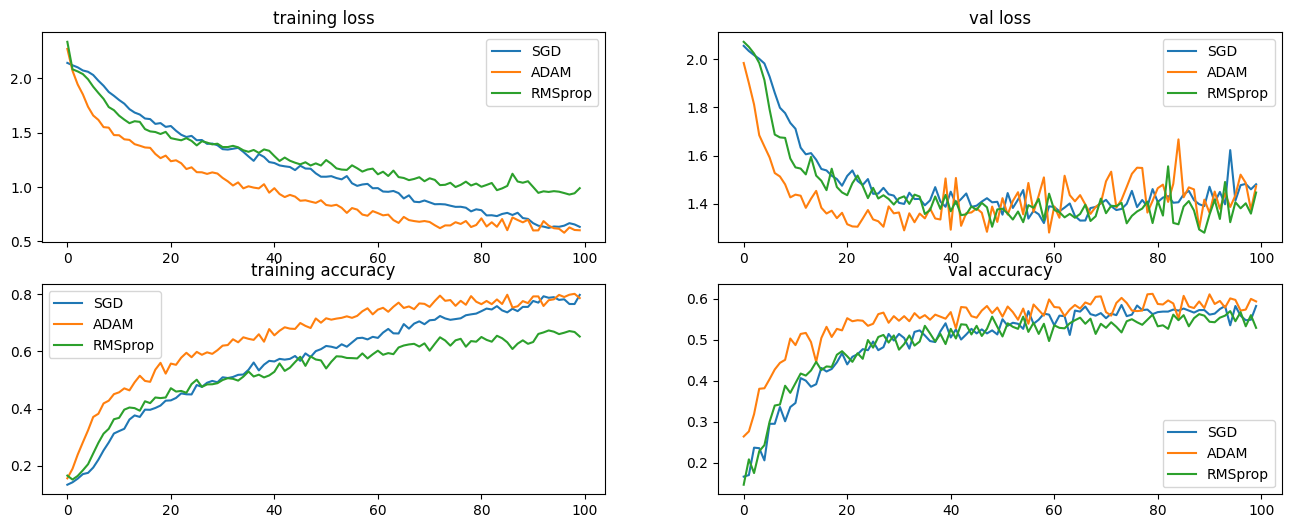

In [42]:
# plot the losses and accuracies of all models
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="SGD")
ax1.plot(losses2["train"], label="ADAM")
ax1.plot(losses3["train"], label="RMSprop")
ax1.set_title("training loss")
ax1.legend()

ax2.plot(losses["val"], label="SGD")
ax2.plot(losses2["val"], label="ADAM")
ax2.plot(losses3["val"], label="RMSprop")
ax2.set_title("val loss")
ax2.legend()

ax3.plot(hist["train"],label="SGD")
ax3.plot(hist2["train"],label="ADAM")
ax3.plot(hist3["train"],label="RMSprop")
ax3.set_title("training accuracy")
ax3.legend()

ax4.plot(hist["val"],label="SGD")
ax4.plot(hist2["val"],label="ADAM")
ax4.plot(hist3["val"],label="RMSprop")
ax4.set_title("val accuracy")
ax4.legend() 

## Mixing the Bovw and the Mlp

In [204]:
from typing import *
import pickle

def read_pickle(filepath:str) -> Any:
    """
    Read and deserialize a pickled object from the specified file.

    Parameters:
        filepath (str): The path to the file containing the pickled object.

    Returns:
        Any: The deserialized object from the pickled file.
    """
    with open(filepath, "rb") as file:
        load_file = pickle.load(file)

    return load_file

def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)

        
    
class BoVW():
    def __init__(self, config, size_per_class=1e9, preload_features=False, folder_path_train='./MIT_split/train', folder_path_test='./MIT_split/test'):
        
        le = LabelEncoder()
        self.config = config
        
        self.train_dataset = {'image_paths': [], 'labels': []}
        self.test_dataset = {'image_paths': [], 'labels': []}
        

        for label in os.listdir(folder_path_train):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_train, label))):
                self.train_dataset['image_paths'].append(os.path.join(folder_path_train, label, image_name))
                self.train_dataset['labels'].append(label)

                # good for making a small test
                if i >= size_per_class:
                    break
                    
        #self.train_dataset['labels'] = le.fit_transform(self.train_dataset['labels'])
        
        #randomizer = np.random.randint(len(self.train_dataset['image_paths']), size=len(self.train_dataset['image_paths']))
        
        #self.train_dataset['image_paths'] = list(np.array(self.train_dataset["image_paths"])[randomizer])
        #self.train_dataset['labels'] = list(np.array(self.train_dataset['labels'])[randomizer])
        
        for label in os.listdir(folder_path_test):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_test, label))):
                self.test_dataset['image_paths'].append(os.path.join(folder_path_test, label, image_name))
                self.test_dataset['labels'].append(label)
                
                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.train_dataset['labels'] = np.array(self.train_dataset['labels'])
        self.test_dataset['labels'] = np.array(self.test_dataset['labels'])
        self.train_features_cluster, self.train_features_level, self.test_features_level = self._compute_features(preload=preload_features)
        
        # Classification
        if self.config['classifier'] == 'knn':
            if self.config.get("metric", None) is not None:
                self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neighbors'], algorithm=self.config['algorithm'], metric=self.config["metric"])
            else:
                self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neighbors'], algorithm=self.config['algorithm'], p=self.config["p"])

        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], degree=self.config['degree_pol'], gamma = 'auto', C = self.config['C'], probability=True, random_state=123)
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', solver='lbfgs', C = self.config['C'], n_jobs=-1, random_state=123)
            

        self.dim_red = None
        if self.config['n_components'] > 0:
            self.dim_red = PCA(n_components = self.config['n_components'])

        # Standarization
        self.scaler = None
        if self.config['scaler']:
            self.scaler = StandardScaler(with_mean=True, with_std=True)


    def _compute_descriptor_level(self, gray_chunk, color_chunk):

        if self.config['descriptor'] == 'dense_sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create()
            kp = [cv2.KeyPoint(x, y, self.config['step_size']) for y in range(0, gray_chunk.shape[0], self.config['step_size'])
                                                                for x in range(0, gray_chunk.shape[1], self.config['step_size'])]
            _, des = sift.compute(gray_chunk, kp)

        elif self.config['descriptor'] == 'sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create(nfeatures=self.config["n_features"])
            _, des = sift.detectAndCompute(gray_chunk, None)

        elif self.config['descriptor'] == 'akaze':
            # Initialize AKAZE extractor
            akaze = cv2.AKAZE_create(descriptor_type=cv2.AKAZE_DESCRIPTOR_KAZE, threshold=0.0001)
            _, des = akaze.detectAndCompute(color_chunk, None)
          
        return des

    def _compute_features(self, preload=False):
        
        if preload:
            level_features_train = read_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            level_features_test = read_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            cluster_features_train = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in level_features_train], axis=0)
            return cluster_features_train, level_features_train, level_features_test

        cluster_features_train = []
        level_features_train, level_features_test = [], []
        # Iterate over all files in the directory
        for i,dataset in enumerate([self.train_dataset['image_paths'], self.test_dataset['image_paths']]):
            for filename in tqdm.tqdm(dataset, desc='Extracting features from dataset %d' % i):
                
                # Load the imag
                img = cv2.imread(filename)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_blocks = split_image_into_blocks(img, self.config['level_pyramid'])
                gray_blocks = split_image_into_blocks(gray, self.config['level_pyramid'])

                level_features = [] # levels x np.array([n_features, 128])
                for c_block, g_block in zip(img_blocks, gray_blocks):
                    des = self._compute_descriptor_level(g_block, c_block)

                    if des is not None:
                        level_features.append(des.astype(np.float64)) # may contain different number of features for each level
                    else:
                        hist, _ = np.histogramdd(c_block.reshape(-1, 3), bins = 128 if self.config['descriptor'] != 'akaze' else 64)
                        level_features.append((hist.sum(axis=1).sum(axis=0) / hist.sum()).reshape(1,-1).astype(np.float64))
                
                cluster_features = np.concatenate(level_features, axis=0) # shape (levels * n_features, 128), n_features does not need to be the same for each level

                if i == 0:
                    cluster_features_train.append(cluster_features)
                    level_features_train.append(level_features)
                else:
                    level_features_test.append(level_features)

        # saving features -> from level_features we can get the cluster_features
        os.makedirs(os.path.join(".", "descriptors", "train"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_train)
        
        os.makedirs(os.path.join(".", "descriptors", "test"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_test)
        return np.concatenate(cluster_features_train, axis=0), level_features_train, level_features_test

    def fit(self, train_features_cluster=None, train_features_level=None, y_train_labels=None):

        if train_features_cluster is None and train_features_level is None and y_train_labels is None:
            train_features_cluster = self.train_features_cluster
            train_features_level = self.train_features_level
            y_train_labels = self.train_dataset['labels']
         
        if self.config["fisher"]:
            self.cluster = learn_gmm(self.train_features_cluster, n_modes=self.config["n_words"], gm_args={'n_init': 1, 'max_iter': 50, 'covariance_type':'diag'})
        else:
            self.cluster = MiniBatchKMeans(n_clusters=self.config['n_words'], n_init='auto', compute_labels=True, random_state=123)
            self.cluster.fit(self.train_features_cluster)
        
        visual_words_train = self._extract_visual_words(train_features_level)
        
        if self.config['scaler']:
            visual_words_train = self.scaler.fit_transform(visual_words_train)
        
        if self.dim_red is not None:
            visual_words_train = self.dim_red.fit_transform(visual_words_train)

        
         # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_distance(visual_words_train, visual_words_train)

        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_kernel(visual_words_train, visual_words_train)
            
        self.classifier.fit(visual_words_train, y_train_labels)
        


    def predict(self, test_features_level=None):
        
        if test_features_level is None:
            test_features_level = self.test_features_level

        visual_words_test = self._extract_visual_words(test_features_level)

        if self.config['scaler']:
            visual_words_test = self.scaler.transform(visual_words_test)
        
        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)

        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            visual_words_test = histogram_intersection_distance(visual_words_test, self.visual_words_train_old)
            
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            visual_words_test = histogram_intersection_kernel(visual_words_test, self.visual_words_train_old)
    

        return self.classifier.predict(visual_words_test), self.classifier.predict_proba(visual_words_test)
    
    def _extract_test_visual_words(self):
        
        test_features_level = self.test_features_level
        
        visual_words_test = self._extract_visual_words(test_features_level)
        
        if self.config['scaler']:
            visual_words_test = self.scaler.transform(visual_words_test)

        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)
        
        return visual_words_test
    
    def _extract_train_visual_words(self):
        train_features_level = self.train_features_level
        visual_words_train = self._extract_visual_words(train_features_level)
        
        if self.config['scaler']:
            visual_words_train = self.scaler.transform(visual_words_train)

        if self.dim_red is not None:
            visual_words_train = self.dim_red.transform(visual_words_train)
        
        return visual_words_train 

    def _extract_visual_words(self, features_level=None):



        dim_des = 128 if self.config['descriptor'] != 'akaze' else 64
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        visual_words = np.zeros((len(features_level), self.config['level_pyramid'], dim_size), dtype=np.float64) # we will need shape (n_images, dim_size)


        for i in range(len(features_level)):
            for l in range(self.config['level_pyramid']):
                words = self.cluster.predict(features_level[i][l]) if not self.config["fisher"] else fisher_vector(features_level[i][l], self.cluster)
                visual_words[i,l,:] = np.bincount(words, minlength=self.config['n_words']) if not self.config["fisher"] else words

        visual_words = visual_words.reshape(len(features_level), -1) # get shape (n_images, dim_size*level_pyramid)
        
        return visual_words
        
        
    
def cross_validation(bovw):
    
    kf = KFold(n_splits=bovw.config['n_folds'], shuffle=True, random_state=123)
    predictions, y_scores, labels = [], [], []

    for train_index, test_index in tqdm.tqdm(kf.split(bovw.train_features_level), desc='Cross validation', total=bovw.config['n_folds']):
        # Split features and labels for this fold
        X_train_level, X_test_level = [bovw.train_features_level[i] for i in train_index] , [bovw.train_features_level[i] for i in test_index]
        y_train_level, y_test = bovw.train_dataset['labels'][train_index], bovw.train_dataset['labels'][test_index]

        X_train_cluster = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in X_train_level], axis=0)

        # Fit the classifier
        
        bovw.fit(X_train_cluster, X_train_level, y_train_level)
        # Predict the test set
        pred, y_score = bovw.predict(X_test_level)
        
        y_scores.append(y_score)
        predictions.append(pred)
        labels.append(y_test)

    return predictions, y_scores, labels
    
def log_metrics(config, predictions, y_scores, y_test, plot='micro'):
    wandb.log({
        'accuracy': np.mean([accuracy(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_precision': np.mean([average_precision(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_recall': np.mean([average_recall(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_f1': np.mean([average_f1(predictions[i], y_test[i]) for i in range(len(predictions))]),
    })

    # ----------------- #
    #Log ROC curve
    
    n_folds = config['n_folds']
    result_auc = []
    for n in range(n_folds):
        y_onehot_test = LabelBinarizer().fit_transform(y_test[n])
        if plot == 'micro':
            fpr, tpr = compute_micro_roc_curve(y_onehot_test, y_scores[n])
        else:
            fpr, tpr = compute_macro_roc_curve(y_onehot_test, y_scores[n])

        #compute AUC
        result_auc.append(auc(fpr, tpr))
    wandb.log({'AUC': np.mean(result_auc)})



def sweep_bovw():
    with wandb.init() as run:
        # Get hyperparameters
        config = run.config
        if config['fisher']:
            config['n_words'] = config['n_words'] // 2
        print(config)
        bovw = BoVW(config)
        predictions, y_scores, labels = cross_validation(bovw)
        log_metrics(config, predictions, y_scores, labels)


In [205]:
bovw = read_pickle("bovw.pkl")

In [206]:
bovw._extract_visual_words(bovw.train_features_level).shape

(1881, 890)

In [207]:
R = torchvision.transforms.Resize((32, 32))
X = []
y = []
with torch.no_grad():
    for path, label in zip(bovw.train_dataset["image_paths"], bovw.train_dataset["labels"]):
        img = torchvision.io.read_image(path)/255
        img = R(img).cuda()
        embedding = model2(img)[-1]
        X.append(embedding.cpu().numpy())
        y.append(label)

        

In [208]:
X_test = []
y_test = []
with torch.no_grad():
    for path, label in zip(bovw.test_dataset["image_paths"], bovw.test_dataset["labels"]):
        img = torchvision.io.read_image(path)/255
        img = R(img).cuda()
        embedding = model2(img)[-1]
        X_test.append(embedding.cpu().numpy())
        y_test.append(label)


In [209]:
X_train = np.array(X).squeeze()
y_train = np.array(y)

X_test = np.array(X_test).squeeze()
y_test = np.array(y_test)

## Training SVM from best MLP but getting the layer before the last one

In [210]:
from sklearn.svm import SVC
def accuracy(predictions, labels):
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

def compute_macro_roc_curve(y_onehot_test, y_score):
    """
    Computes the ROC curve and ROC area for each class.
    
    Args:
    y_onehot_test: array-like of shape (n_samples, n_classes)
    prob_matrix: array-like of shape (n_samples, n_classes)
    """
    n_classes = y_onehot_test.shape[1]
    # store the fpr, tpr
    fpr, tpr = dict(), dict()
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    return fpr_grid, mean_tpr / n_classes

def compute_micro_roc_curve(y_onehot_test, y_score):
    """
    Computes the micro ROC curve and ROC area.
    
    Args:
    y_onehot_test: array-like of shape (n_samples, n_classes)
    prob_matrix: array-like of shape (n_samples, n_classes)
    """
    # Compute micro-average ROC curve
    fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())

    return fpr, tpr


In [113]:
clf = SVC(probability=True)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

In [211]:
from sklearn.model_selection import train_test_split, GridSearchCV

clf = SVC()
param_grid = {
    'C': [0.1, 1, 10],           
    'kernel': ['linear', 'rbf'],      
    'gamma': [0.01, 0.1, 1, 'auto']   
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


In [212]:
grid_search.best_score_

0.7443055477171399

In [214]:
accuracy(grid_search.predict(X_test), y_test)
predictions = grid_search.predict(X_test)

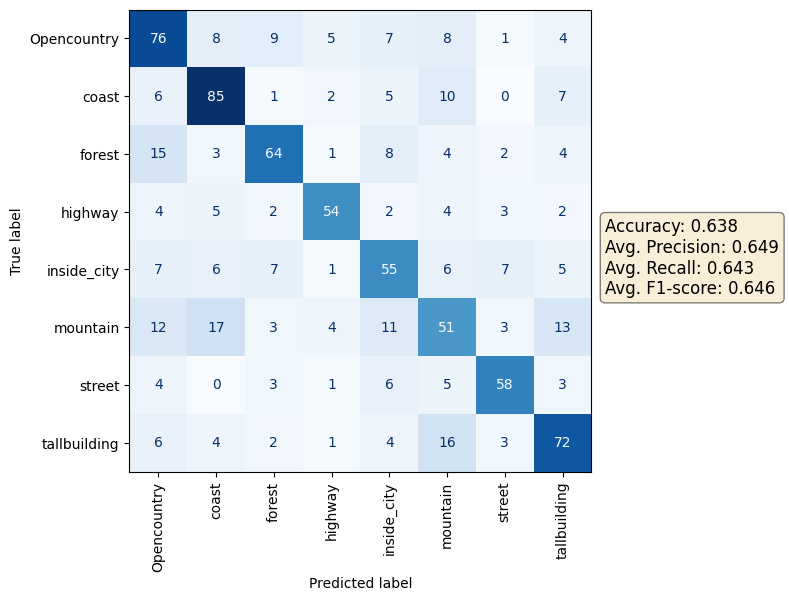

In [216]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(bovw.test_dataset['labels']))
_, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)

# Adding text for metrics
textstr = '\n'.join((
    f'Accuracy: {accuracy(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. Precision: {average_precision(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. Recall: {average_recall(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. F1-score: {average_f1(predictions, bovw.test_dataset["labels"]):.3f}'))

# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place a text box in upper left in axes coords
ax.text(1.03, 0.55, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.show()

['Opencountry' 'coast' 'forest' 'highway' 'inside_city' 'mountain'
 'street' 'tallbuilding']


Text(0.5, 1.0, 'Micro-averaged Precision-Recall curve')

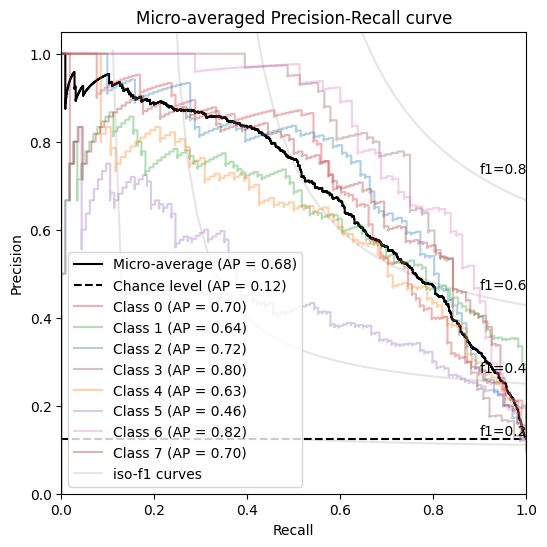

In [117]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]
enc = LabelBinarizer()


y_onehot_test = OneHotEncoder(handle_unknown='ignore').fit_transform(np.array(bovw.test_dataset['labels']).reshape(-1, 1)).toarray()
clas = (np.unique(bovw.test_dataset['labels']))
n_classes = y_onehot_test.shape[1]
print(clas)

# For each class
precision_dict  = dict()
recall_dict  = dict()
average_precision_dict = dict()
for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision_dict["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")


from collections import Counter

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_dict["micro"],
    precision=precision_dict["micro"],
    average_precision=average_precision_dict["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(ax=ax, name="Micro-average", plot_chance_level=True, color='black')


for i, (cl, color) in enumerate(zip(clas, colors)):
    display = PrecisionRecallDisplay(
        recall=recall_dict[i],
        precision=precision_dict[i],
        average_precision=average_precision_dict[i],
    )
    display.plot(ax=ax, name=f"Class {i}", color=color, alpha=0.35)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Micro-averaged Precision-Recall curve")

In [199]:
y_score

array([[4.54392529e-03, 2.75988765e-03, 8.02267066e-03, ...,
        3.59511621e-03, 1.55402806e-02, 7.66624989e-04],
       [1.34921409e-01, 6.74980511e-03, 2.79614993e-03, ...,
        1.49592251e-02, 2.13467980e-02, 7.35422663e-04],
       [2.99373082e-03, 2.35284694e-03, 1.66233594e-02, ...,
        8.51105971e-03, 3.66017623e-01, 6.22267875e-03],
       ...,
       [8.24176056e-03, 7.35768651e-03, 7.28626985e-04, ...,
        3.15579217e-03, 8.37834247e-03, 4.90007928e-04],
       [4.43395628e-01, 1.81017376e-01, 3.95284630e-02, ...,
        2.04234473e-02, 3.55694217e-03, 1.84225583e-03],
       [7.29079125e-03, 1.15851934e-02, 8.87127797e-04, ...,
        4.02650443e-03, 4.33398775e-03, 2.13257000e-04]])